# Spatial DFBA Model

This notebook demonstrates a Spatial Dynamic Flux Balance Analysis (DFBA) model, simulating and visualizing biomass concentrations over time in a two-dimensional (2D) field. The model integrates diffusion, advection, and sinking mechanisms to show how these processes influence biomass distributions at each timestep across the grid bins.

**Key components of the notebook:**
- **Initialization**: Setting up the spatial environment with defined bounds, bins, and initial states for molecules and species.
- **Process Simulation**: Using the `SpatialDFBA` class to simulate species growth based on local conditions and kinetic parameters.
- **Diffusion and Advection**: Applying diffusion and advection processes to update molecule concentrations and biomass distributions.
- **Visualization**: Plotting the objective flux and spatial fields to visualize biomass and molecule concentrations over time.

Run the notebook to observe how different species interact and grow in a spatially heterogeneous environment, influenced by diffusion, advection, and sinking mechanisms.


## Imports

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from vivarium.core.engine import Engine
from processes.spatial_dfba import SpatialDFBA
from plots.field import plot_objective_flux, plot_fields_temporal
from IPython.display import display, HTML
import imageio.v2 as imageio
import io
import base64

In [2]:
### XXXXX FIX THIS ISSUE #####
base_directory = '/Users/amin/Desktop/VivaComet'
os.chdir(base_directory)

# Check the current working directory to confirm it's set correctly
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/amin/Desktop/VivaComet


In [ ]:
# Configuration
total_time = 1
config = {
    'bounds': [10, 10],  # dimensions of the environment
    'nbins': [10, 10],   # division into bins
    'molecules': ['glucose', 'oxygen'],  # available molecules
    'species_info': [
        {
            'name': 'Alteromonas',
            'model': 'data/Alteromonas_Model.xml',  # Path to FBA model file
            'diffusion_rate': 0.001,
            'advection_vector': (0.0, -0.01),
            'flux_id_map': {
                'glucose': 'EX_cpd00027_e0',
                'oxygen': 'EX_cpd00007_e0'
            },
            'kinetic_params': {
                'glucose': (0.5, 2.0),  # Km, Vmax for glucose
                'oxygen': (0.3, 5.0),   # Km, Vmax for oxygen
            }
        },
        {
            'name': 'ecoli',
            'model': 'data/iECW_1372.xml',  # Path to E. coli model file
            'diffusion_rate': 0.001,
            'advection_vector': (0.0, -0.01),
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'oxygen': 'EX_o2_e'
            },
            'kinetic_params': {
                'glucose': (0.4, 1.5),  # Km, Vmax for glucose
                'oxygen': (0.25, 4.5),  # Km, Vmax for oxygen
            }
        }
    ]
}

# Initialize the process
spatial_dfba = SpatialDFBA(config)
initial_state = spatial_dfba.initial_state({'random': {'glucose': 5.0, 'oxygen': 2.0, 'species': {'ecoli': 0.5, 'Alteromonas': 0.5 }}})

# Create the simulation engine
sim = Engine(
    initial_state=initial_state,
    processes={'spatial_dfba': spatial_dfba},
    topology={'spatial_dfba': {
        'fields': ('fields',),
        'species': ('species',),
        'dimensions': ('dimensions',),
    }}
)

# Run the simulation
sim.update(total_time)

# Get the results
data = sim.emitter.get_timeseries()

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas
Loaded model for ecoli

Simulation ID: a5a00058-2136-11ef-ab62-ba21c95c07d8
Created: 06/02/2024 at 19:20:06


In [ ]:
data

In [8]:
# Plot the objective flux
plot_objective_flux(
    data,
    time_points=[0, int(total_time/4), int(total_time/2), int(3*total_time/4), total_time-1],
    species_names=[species['name'] for species in config['species_info']],
    out_dir='./out',
    filename='objective_flux_plot'
)

In [10]:
plot_objective_flux

<function plots.field.plot_objective_flux(data, time_points, species_names, out_dir='out', filename='objective_flux')>

KeyError: 'ecoli'

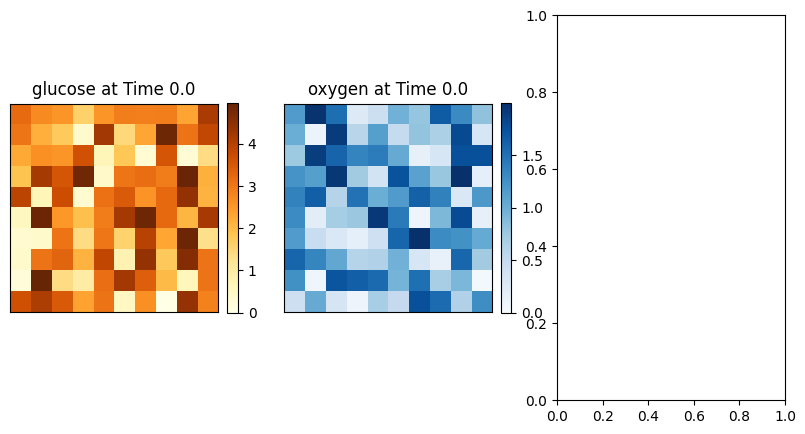

In [9]:

# Function to plot fields over time and save as GIF
def plot_fields_temporal_to_gif(
        fields_data,
        desired_time_points,
        actual_time_points,
        filename='fields_over_time.gif',
        molecule_colormaps={'glucose': 'YlOrBr', 'oxygen': 'Blues', 'ecoli': 'Purples'},
        plot_fields=["glucose", "oxygen", "ecoli"],
        skip_frames=1
):
    if not os.path.exists('temp'):
        os.makedirs('temp', exist_ok=True)

    # Convert desired and actual time points to float for accurate indexing
    desired_time_points = [float(time) for time in desired_time_points]
    actual_time_points = [float(time) for time in actual_time_points]
    num_molecules = len(plot_fields)
    num_times = len(desired_time_points)
    images = []

    # Calculate global min/max for each molecule across all timepoints
    global_min_max = {}
    for molecule in fields_data.keys():
        if molecule not in plot_fields:
            continue
        all_data = np.concatenate([np.array(times_data) for times_data in fields_data[molecule]], axis=0)
        global_min_max[molecule] = (np.min(all_data), np.max(all_data))

    for time_idx, desired_time in enumerate(desired_time_points):
        if desired_time in actual_time_points:
            actual_idx = actual_time_points.index(desired_time)
            fig, axs = plt.subplots(1, num_molecules, figsize=(10, 5), squeeze=False)

            for mol_idx, molecule in enumerate(plot_fields):
                data_array = np.array(fields_data[molecule][actual_idx])  # Accessing the time-specific data
                ax = axs[0, mol_idx]
                cmap = molecule_colormaps.get(molecule, 'viridis')  # Default to 'viridis' if molecule not in dict
                vmin, vmax = global_min_max[molecule]  # Use global min/max
                cax = ax.imshow(data_array, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
                ax.set_title(f'{molecule} at Time {desired_time}', fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
                # Add a colorbar for each subplot
                cb = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
                cb.ax.tick_params(labelsize=10)

            plt.tight_layout()
            buf = io.BytesIO()
            plt.savefig(buf, format='png', dpi=120)
            buf.seek(0)
            images.append(imageio.imread(buf))
            buf.close()
            plt.close(fig)

    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Fields Over Time" style="max-width:100%;"/>'))

# Example usage
time_list = [i for i in range(total_time)]

plot_fields_temporal_to_gif(
    data['fields'], 
    desired_time_points=time_list, 
    actual_time_points=time_list, 
    filename='fields_over_time.gif'
)

def display_gif(filename):
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    html_str = f'<img src="{data_url}" alt="Fields Over Time" style="max-width:100%;"/><br/>'
    html_str += f'<a href="{data_url}" download="{filename}">Download GIF</a>'
    display(HTML(html_str))

# Display the GIF
display_gif('fields_over_time.gif')

# Show topology plot
from vivarium.plots.topology import plot_topology
fig = plot_topology(spatial_dfba)
plt.show()